In [3]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import datetime as dt
import numpy.random as rd
import matplotlib.pyplot as plt
import os
import scipy.stats as si

In [4]:
#unclear if necessary to use in jupyter
# os.chdir(os.path.dirname(__file__))
# print(os.getcwd())

NameError: name '__file__' is not defined

In [5]:
def load_financial_data(name, output_file):
    try:
        df = pd.read_pickle(output_file)
        print('File data found...reading',name,'data')
    except FileNotFoundError:
        print('File not found...downloading', name, 'data')
        df = data.DataReader(name, 'yahoo', '2001-01-01', '2019-11-24')
        df.to_pickle(output_file)
    return df

def euro_vanilla_call(S, K, T, r, d, sigma):
    
    #S: spot price
    #K: strike price
    #T: time to maturity/
    #r: interest rate
    #sigma: volatility of underlying asset
    d1 = (np.log(S / K) + (r - d + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - d - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    call = (S * si.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-(r-d) * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call

In [6]:
def get_logreturn(yahoo_dataframe):
    out = pd.DataFrame(index = yahoo_dataframe.index)
    prices = yahoo_dataframe.Close
    days = pd.Series(yahoo_dataframe.index).dt.day
    daydelta = days.iloc[1:].values - days.iloc[:-1].values
    out['LogReturn'] = np.log(prices.shift(-1)/prices).dropna()/np.sqrt(daydelta)
    return out

def get_sigma():
    daybasis = 252
    SP500 = load_financial_data('^GSPC', '^GSPC_data.pkl')
    lreturns = get_logreturn(SP500)
    pastyears = lreturns.iloc[-n_years*daybasis:]
    dailyvol = pastyears.std()[0]
    yearlyvol = dailyvol*np.sqrt(daybasis)
    return yearlyvol

def get_latest_price():
    return load_financial_data('^GSPC', '^GSPC_data.pkl').iloc[-1].Close

In [8]:
SP500 = load_financial_data('^GSPC', '^GSPC_data.pkl')
lreturns = get_logreturn(SP500)

File data found...reading ^GSPC data


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


In [9]:
daybasis = 252
n_years = 3
pastyears = lreturns.iloc[-n_years*daybasis:]
dailyvol = pastyears.std()[0]

yearlyvol = dailyvol*np.sqrt(daybasis)
dailyalpha = pastyears.mean() + dailyvol**2/2
yearlyalpha = dailyalpha*daybasis

In [10]:
num_random = 10000
def RegenerateRandomNumbers():
    global Z1, Z2
    Z1 = rd.randn(num_random,1)
    Z2 = rd.randn(num_random,1)
    #control variate method, denorming Z1 and Z2
    Z1 = (Z1-Z1.mean())/Z1.std()
    Z2 = (Z2-Z2.mean())/Z2.std()

RegenerateRandomNumbers();
    
def SimulateStock(S0,t, sigma, Z):
    Sn = S0*np.exp(( r - d - sigma**2/2)*t + sigma*Z * np.sqrt(t))
    return Sn

def SimulateAllRelevantStocks(S0, t, T, sigma, Z1, Z2):
    Shalf = S0*np.exp(( r - d - sigma**2/2)*t + sigma*Z1* np.sqrt(t))
    S1 = Shalf*np.exp( ( r - d - sigma**2/2)*(T-t) + sigma*Z2 * np.sqrt(T-t)) 
    return Shalf, S1
    
def TriggerPayoff(Q, F, Shalf, S1):
#def TriggerPayoff(Q, F):
    """ calculates trigger payoff for a given exercise level Q via Monte Carlo simulation"""
    
#    Shalf = SimulateStock(S,trig, Z1)
#    Shalf = S*np.exp( ( r - d - sigma**2/2)*trig + sigma*Z1 * np.sqrt(trig)) 
    
#    S1 = Shalf*np.exp( ( r - d - sigma**2/2)*(T-trig) + sigma*Z2 * np.sqrt(T-trig)) 
#    S1 = SimulateStock(Shalf, T-trig, Z2)
    
    Payoff = np.maximum(S1-K, 0)
    Payoff[Shalf < Q] = F
#    meanPayoff = np.smean(Payoff)
#    return np.hstack((Shalf, Payoff))
#    return meanPayoff*np.exp(-r*T)
    return Payoff

def TriggerMeanPayoff(Q,F, Shalf, S1):
    return np.mean(TriggerPayoff(Q,F, Shalf, S1))*np.exp(-r*T)

def HalfYearCall(Shalf):
#    Shalf = S*np.exp( ( r - d - sigma**2/2)*trig + sigma*Z1 * np.sqrt(trig)) 
    Payoff = np.maximum(Shalf-K,0)
#    return np.mean(Payoff)*np.exp(-r*T)
    return Payoff

def HalfYearPayoff(Shalf):
    return np.mean(HalfYearCall(Shalf))*np.exp(-r*T)
     
#theoretically, at T=.5, the option is either an option to get a fixed payment or a call.
def TwoPeriodEuroCall(S1):
    """calculates the value of a vanilla european call using common random numbers of the shout option
    honeslty at this point just pretend this isn't a thing
    """
#    Shalf = S*np.exp( ( r - d - sigma**2/2)*trig + sigma*Z1 * np.sqrt(trig)) 
#    S1 = Shalf*np.exp( ( r - d - sigma**2/2)*(T-trig) + sigma*Z2 * np.sqrt(T-trig))
    Payoff = np.maximum(S1-K,0)
#    return np.mean(Payoff)*np.exp(-r*T)
    return Payoff

def TwoPeriodEuroPayoff(S1):
    return np.mean(TwoPeriodEuroCall(S1))*np.exp(-r*T)

#%% sets parameters
sigma = yearlyvol
T = 1
trig = .5
r = .0158
d = .0185
S = SP500.iloc[-1].Close
F = 10
#K = 3150

In [11]:
# reads option data
options = pd.read_excel("options.xlsx")
#options = pd.read_csv("options.csv")
c1yr = options.loc[:, 'Dec 2020 call'].values # traded call options price
chalfyr = options.loc[:, 'Jun 2020 call'].values
Ks = options.loc[:, 'strike'].values/100 # strike price
# suppose maturity = 1 
bs_c = []

for i in Ks:
    bs_c.append(euro_vanilla_call(S, i, T, r, d,sigma))
    
bs_c = np.asarray(bs_c, dtype=np.float64).reshape(-1,1)
#Xs is a matrix of theoretical black scholes price and strike. 
Xs = np.hstack((bs_c, Ks.reshape(-1,1)))

,strike,Dec 2020 call,Dec 2020 put,Jun 2020 call,Jun 2020 put
0,307500,187.4,148.8,165.1,127.1
1,308000,184.2,150.6,161.7,128.6
2,309000,178.0,154.3,154.9,131.8
3,310000,171.9,158.1,148.3,135.1
4,311000,166.0,162.0,141.8,138.5
5,312000,160.1,166.0,135.4,142.0
6,312500,157.2,168.1,132.2,143.9
7,313000,154.4,170.2,129.1,145.7
8,314000,148.8,174.5,122.9,149.5
9,315000,143.3,178.9,116.9,153.4


slope:  1.2590542854175693
intercept:  -11.739911398243322
r2 score:  0.9999899259644417


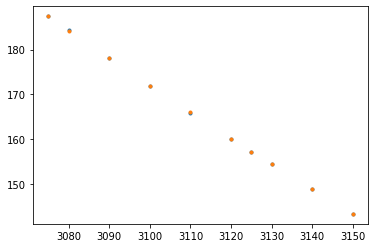

In [13]:
#linear regression to connect the black scholes call price to the 1 year call price
# establishes a link between the theoretical black scholes and market observed prices
# so, using a given result from the black scholes formula, we can fill in the blanks for what the market would say
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
regressor = LinearRegression()
#regressorb = LinearRegression()
model_1 = regressor.fit(bs_c, c1yr)

b_year, a_year = model_1.coef_[0], model_1.intercept_

print('slope: ',b_year)
print('intercept: ',a_year)
print('r2 score: ',r2_score(model_1.coef_*bs_c+model_1.intercept_, c1yr))

#multlin_1 = regressorb.fit(Xs,c1yr)
#print(multlin_1.coef_)
#print(multlin_1.intercept_)
#print(r2_score( np.sum(multlin_1.coef_*Xs, axis = 1)+multlin_1.intercept_, c1yr))

plt.plot(Ks, model_1.coef_*bs_c+model_1.intercept_, '.')
#plt.plot(Ks, np.sum(multlin_1.coef_*Xs, axis = 1)+multlin_1.intercept_, '.')
plt.plot(Ks,c1yr, '.')

slope:  1.35193212997858
intercept:  5.464200693491563
r2 score:  0.999769619955707


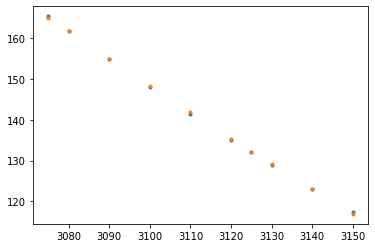

In [14]:
# suppose maturity = 0.5 
# regresses half year black scholes theoretical call price to real call price
bs_c2 = []
for i in Ks:
    bs_c2.append(euro_vanilla_call(S, i, trig, r, d,sigma))
    
bs_c2 = np.asarray(bs_c2, dtype=np.float64).reshape(-1,1)

regressor2 = LinearRegression()
model_2 = regressor2.fit(bs_c2, chalfyr)

b_half, a_half = model_2.coef_[0], model_2.intercept_
print('slope: ', b_half)
print('intercept: ', a_half)
print('r2 score: ',r2_score(model_2.coef_*bs_c2+model_2.intercept_, chalfyr))

plt.plot(Ks, model_2.coef_*bs_c2+model_2.intercept_, '.')
plt.plot(Ks, chalfyr, '.')

In [15]:
# for strikes between  3075 and 3150, for options of 1 year and half a year
# of course, this might not be necessary -- it might be simpler to get straight to the point
# which means regress directly: (what to what?)
# simulate shout values, let those be Y
# xs are then... 
# I guess it could be with different strike prices to empirically determine a payoff function for a shout
# theoretically with a shout F of 0, the damn thing should converge to a european call
# anyways, what we want is an equation of form a + b1 O1 + b2 O2,
# where a is a fixed cost, b1 is the relation to the half year option, and b2 is the relation to the year option
# how do we benchmark this? mentally I'm stuck
# information we have: simulated half year stock prices, full year stock prices
# market data: half year option, full year option
# option one: multilinear regression, monte carlo half year to known option price, full year to known option

# wait: what's the x data and y? the y is the simulated shout option price.
# the xs are therefore some combination of the simulated stock prices and the known real option prices
# so for each loop: simulate a shout price, as well as the two stock prices at each time
# then do the regression on the value of the OPTION at time .5 and time 1
# shout = a + b1 * option.5 + b2*option1
# then, we use the actual values of the options at .5 and 1 to get the 'actual value' of the shout??
print(a_year, b_year, a_half, b_half)

def scaled_eurocall(bsprice, alpha, beta):
    return bsprice*beta + alpha

-11.739911398243322 1.2590542854175693 5.464200693491563 1.35193212997858


In [16]:
placekey = 5
k = Ks[placekey]
K = k
minrange = round((S+K)/2 -750)
maxrange = round((S+K)/2 +750)
step = .1
steprange = np.arange(minrange, maxrange, step)

def estimate_prices(k, sigma_):

    T = 1
    trig = .5
    r = .0158
    d = .0185
    S = SP500.iloc[-1].Close
    F = 100 #we want some F that makes the shout more valuable than the vanilla
#    F = 0 #dummy to check convergence to vanilla
    # when this F=0 condition is true, we would expect the value to be identical to vanilla.
    
    K = k

    payoffs = []
    basepays = []
    eurocall = []
    trueeurocall = []
    strikes = []
    
    Shalf, S1 = SimulateAllRelevantStocks(S, trig, T, sigma_, Z1, Z2)
    
    simeurcall = TwoPeriodEuroPayoff(S1) #common random number eurocall
    
    
    bseurcall = scaled_eurocall(euro_vanilla_call(S,K,T,r,d,sigma_), a_year, b_year )
    #analytical eurocall, scaled to market data
    
    for i in steprange:
        # this payoff takes the control variate technique and applies it to the trigger payoff
        # we know what the analytical european call price should be
        # we can simulate the european call price using the same common random numbers as the trigger
        # thus, we can correct the effect of the randomnuess on the trigger payoff via:
        # simulated_trigger - simulated_european + analytical_european
        basepay = TriggerMeanPayoff(i,F, Shalf, S1)

        j = basepay - simeurcall + bseurcall
        # I have no idea of this use of control variate is compatible with benchmarking
        # but strictly speaking this is perfectly valid
        #alright, this is valid in the formulation that returns average payoffs
        
        payoffs.append(j)
        basepays.append(basepay)
        
        # these are done to display a straight line of call price. 
#        eurocall.append(simeurcall)
#        trueeurocall.append(bseurcall)
        
        #this is necessary for best q level
        strikes.append(i)
    
#    plt.plot(steprange, payoffs)
#    plt.plot(steprange, trueeurocall)
    
    
    #    plt.plot(steprange, eurocall)
    
    bestq = strikes[payoffs.index(max(payoffs))]
    
    trigger = TriggerPayoff(bestq, F, Shalf, S1)
    
    Xs = np.hstack((HalfYearCall(Shalf), TwoPeriodEuroCall(S1)))
    
    regressor = LinearRegression()
    model = regressor.fit(Xs, trigger)
    
    value = max(payoffs)
#    print('value: ',value, 
##          'true-vanilla: ', trueeurocall[0],    
#          '\n',
#          'unadj value', max(basepays),
##          'sim-vanilla: ', max(eurocall), 
#          '\n',
#          'best Q level: ', bestq)
    return value, bestq, model, payoffs


(189.92542836247304, 0.5870383003080206)
(190.57112962695876, 0.6348862773070358)
0.645701264485723


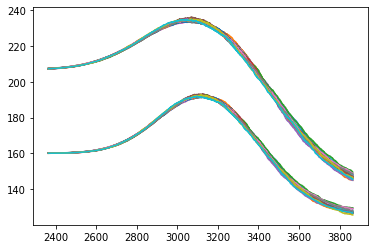

In [17]:
def benchmark_prices(reg_results):
    c1 = c1yr[placekey]
    ch = chalfyr[placekey]
    benchmarkcalls = np.array((ch, c1))
    benchmarkedprices = []
    for reg in reg_results:
    #    price = reg.coef_[0]*ch + reg.coef_[1]*c1 + reg.intercept_
        price = (np.dot(reg.coef_,benchmarkcalls) + reg.intercept_)[0]
        # can also use reg.predict()
#        print(reg.coef_, reg.intercept_)
        benchmarkedprices.append(price)
    return benchmarkedprices
#k = 3120
# referential equivalent for k = 3120:
#placekey = 4
#k = Ks[placekey]
#
#minrange = round((S+K)/2 -750)
#maxrange = round((S+K)/2 +750)
#step = .2
#steprange = np.arange(minrange, maxrange, step)

values_base = []
optimalqs_base = []
regression_results_base = []
payofflist_base = []

values_spread = []
optimalqs_spread = []
regression_results_spread = []
payofflist_spread = []

for j in range(20):        
    RegenerateRandomNumbers()
    
    v, q, rr, ps = estimate_prices(k, yearlyvol)
    values_base.append(v)
    optimalqs_base.append(q)
    regression_results_base.append(rr)
    payofflist_base.append(ps)
    
    v, q, rr, ps = estimate_prices(k, yearlyvol + .03)
    values_spread.append(v)
    optimalqs_spread.append(q)
    regression_results_spread.append(rr)
    payofflist_spread.append(ps)

for payoffs in payofflist_base:
    plt.plot(steprange, payoffs)

for payoffs in payofflist_spread:
    plt.plot(steprange, payoffs)
values_base = np.array(values_base)
optimalqs_base = np.array(optimalqs_base)
prices = np.array(benchmark_prices(regression_results_base))
#values.mean(), values.std(), prices.mean(), prices.std(), optimalqs.mean(), optimalqs.std()
stats_bm = (prices.mean(), prices.std())
print(stats_bm)
   
spread_prices = np.array(benchmark_prices(regression_results_spread))
stats_spread = (spread_prices.mean(), spread_prices.std())
print(stats_spread)
print(stats_spread[0]-stats_bm[0])

In [ ]:
print(optimalqs_base.mean(),np.mean(optimalqs_spread))
# indicates that as vol rises optimal exercise boundary falls
print(np.std(optimalqs_base), np.std(optimalqs_spread))